# SFScores

...

Summary:

- Prediction type: __Regression model__
- Domain: __Retail__
- Prediction target: __Sales__ 
- Population size: __???__

_Author: Dr. Patrick Urbanke_

# Background

...

It has been downloaded from the [CTU Prague relational learning repository](https://relational.fit.cvut.cz/dataset/SFScores) (Motl and Schulte, 2015).

### A web frontend for getML

The getML monitor is a frontend built to support your work with getML. The getML monitor displays information such as the imported data frames, trained pipelines and allows easy data and feature exploration. You can launch the getML monitor [here](http://localhost:1709).

### Where is this running?

Your getML live session is running inside a docker container on [mybinder.org](https://mybinder.org/), a service built by the Jupyter community and funded by Google Cloud, OVH, GESIS Notebooks and the Turing Institute. As it is a free service, this session will shut down after 10 minutes of inactivity.

# Analysis

Let's get started with the analysis and set up your session:

In [1]:
import copy
import os
from urllib import request

import numpy as np
import pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline  

import getml

getml.engine.set_project('sfscores')



Connected to project 'sfscores'


## 1. Loading data

### 1.1 Download from source

We begin by downloading the data from the source file:

In [2]:
conn = getml.database.connect_mariadb(
    host="relational.fit.cvut.cz",
    dbname="SFScores",
    port=3306,
    user="guest",
    password="relational"
)

conn

Connection(conn_id='default',
           dbname='SFScores',
           dialect='mysql',
           host='relational.fit.cvut.cz',
           port=3306)

In [3]:
def load_if_needed(name):
    """
    Loads the data from the relational learning
    repository, if the data frame has not already
    been loaded.
    """
    if not getml.data.exists(name):
        data_frame = getml.data.DataFrame.from_db(
            name=name,
            table_name=name,
            conn=conn
        )
        data_frame.save()
    else:
        data_frame = getml.data.load_data_frame(name)
    return data_frame

In [4]:
businesses = load_if_needed("businesses")
inspections = load_if_needed("inspections")
violations = load_if_needed("violations")

In [5]:
businesses

name,application_date,business_id,postal_code,tax_code,owner_zip,name,latitude,longitude,phone_number,business_certificate,address,city,owner_name,owner_address,owner_city,owner_state
role,time_stamp,join_key,categorical,categorical,categorical,text,unused_float,unused_float,unused_float,unused_float,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string
unit,"time stamp, comparison only",,,,,,,,,,,,,,,
0,NULL,10,94104,H24,94104,Tiramisu Kitchen,37.7911,-122.404,nan,779059,033 Belden Pl,San Francisco,Tiramisu LLC,33 Belden St,San Francisco,CA
1,NULL,24,94104,H24,94104,OMNI S.F. Hotel - 2nd Floor Pantry,37.7929,-122.403,nan,352312,"500 California St, 2nd Floor",San Francisco,OMNI San Francisco Hotel Corp,"500 California St, 2nd Floor",San Francisco,CA
2,NULL,31,94133,H24,94133,Norman's Ice Cream and Freezes,37.8072,-122.419,nan,346882,2801 Leavenworth St,San Francisco,Norman Antiforda,2801 Leavenworth St,San Francisco,CA
3,2001-10-10,45,94110,H24,94114,CHARLIE'S DELI CAFE,37.7471,-122.414,nan,340024,3202 FOLSOM St,S.F.,"HARB, CHARLES AND KRISTIN",1150 SANCHEZ,S.F.,CA
4,NULL,48,94122,H24,94122,ART'S CAFE,37.764,-122.466,nan,318022,747 IRVING St,SAN FRANCISCO,YOON HAE RYONG,1567 FUNSTON AVE,SAN FRANCISCO,CA
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6353,2016-09-23,89335,94102,H25,94102,Breaking Bad Sandwiches,nan,nan,nan,1057025,154 McAllister St,NULL,"JPMD, LLC",662 Bellhurst Lane,Castro Valley,CA
6354,2016-09-23,89336,94109,H26,94109,Miller's Rest,nan,nan,nan,1057746,1085 Sutter St,NULL,"Miller's Rest, LLC",2906 Bush Street,San Francisco,CA


In [6]:
inspections

name,date,business_id,score,type
role,time_stamp,join_key,target,unused_string
unit,"time stamp, comparison only",,,
0,2014-01-14,10,92,Routine - Unscheduled
1,2014-07-29,10,94,Routine - Unscheduled
2,2016-05-03,10,82,Routine - Unscheduled
3,2013-11-18,24,100,Routine - Unscheduled
4,2014-06-12,24,96,Routine - Unscheduled
,...,...,...,...
12882,2016-09-22,89072,90,Routine - Unscheduled
12883,2016-09-12,89198,100,Routine - Unscheduled


In [7]:
violations

name,date,business_id,violation_type_id,risk_category,description
role,time_stamp,join_key,categorical,categorical,text
unit,"time stamp, comparison only",,,,
0,2014-07-29,10,103129,Moderate Risk,Insufficient hot water or running water
1,2014-07-29,10,103144,Low Risk,Unapproved or unmaintained equipment or utensils
2,2014-01-14,10,103119,Moderate Risk,Inadequate and inaccessible handwashing facilities
3,2014-01-14,10,103145,Low Risk,Improper storage of equipment utensils or linens
4,2014-01-14,10,103154,Low Risk,Unclean or degraded floors walls or ceilings
,...,...,...,...,...
36045,2016-08-19,88878,103144,Low Risk,Unapproved or unmaintained equipment or utensils
36046,2016-08-19,88878,103124,Moderate Risk,Inadequately cleaned or sanitized food contact surfaces


### 1.2 Prepare data for getML

getML requires that we define *roles* for each of the columns.

In [8]:
businesses.set_role("business_id", getml.data.roles.join_key)
businesses.set_role("name", getml.data.roles.text)
businesses.set_role(["postal_code", "tax_code", "owner_zip"], getml.data.roles.categorical)
businesses.set_role("application_date", getml.data.roles.time_stamp)

businesses

name,application_date,business_id,postal_code,tax_code,owner_zip,name,latitude,longitude,phone_number,business_certificate,address,city,owner_name,owner_address,owner_city,owner_state
role,time_stamp,join_key,categorical,categorical,categorical,text,unused_float,unused_float,unused_float,unused_float,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string
unit,"time stamp, comparison only",,,,,,,,,,,,,,,
0,NULL,10,94104,H24,94104,Tiramisu Kitchen,37.7911,-122.404,nan,779059,033 Belden Pl,San Francisco,Tiramisu LLC,33 Belden St,San Francisco,CA
1,NULL,24,94104,H24,94104,OMNI S.F. Hotel - 2nd Floor Pantry,37.7929,-122.403,nan,352312,"500 California St, 2nd Floor",San Francisco,OMNI San Francisco Hotel Corp,"500 California St, 2nd Floor",San Francisco,CA
2,NULL,31,94133,H24,94133,Norman's Ice Cream and Freezes,37.8072,-122.419,nan,346882,2801 Leavenworth St,San Francisco,Norman Antiforda,2801 Leavenworth St,San Francisco,CA
3,2001-10-10,45,94110,H24,94114,CHARLIE'S DELI CAFE,37.7471,-122.414,nan,340024,3202 FOLSOM St,S.F.,"HARB, CHARLES AND KRISTIN",1150 SANCHEZ,S.F.,CA
4,NULL,48,94122,H24,94122,ART'S CAFE,37.764,-122.466,nan,318022,747 IRVING St,SAN FRANCISCO,YOON HAE RYONG,1567 FUNSTON AVE,SAN FRANCISCO,CA
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6353,2016-09-23,89335,94102,H25,94102,Breaking Bad Sandwiches,nan,nan,nan,1057025,154 McAllister St,NULL,"JPMD, LLC",662 Bellhurst Lane,Castro Valley,CA
6354,2016-09-23,89336,94109,H26,94109,Miller's Rest,nan,nan,nan,1057746,1085 Sutter St,NULL,"Miller's Rest, LLC",2906 Bush Street,San Francisco,CA


In [9]:
inspections = inspections[~inspections.score.is_nan()].to_df("inspections")

inspections.set_role("business_id", getml.data.roles.join_key)
inspections.set_role("score", getml.data.roles.target)
inspections.set_role("date", getml.data.roles.time_stamp)

inspections

name,date,business_id,score,type
role,time_stamp,join_key,target,unused_string
unit,"time stamp, comparison only",,,
0,2014-01-14,10,92,Routine - Unscheduled
1,2014-07-29,10,94,Routine - Unscheduled
2,2016-05-03,10,82,Routine - Unscheduled
3,2013-11-18,24,100,Routine - Unscheduled
4,2014-06-12,24,96,Routine - Unscheduled
,...,...,...,...
12882,2016-09-22,89072,90,Routine - Unscheduled
12883,2016-09-12,89198,100,Routine - Unscheduled


In [10]:
violations.set_role("business_id", getml.data.roles.join_key)
violations.set_role("date", getml.data.roles.time_stamp)
violations.set_role(["violation_type_id", "risk_category"], getml.data.roles.categorical)
violations.set_role("description", getml.data.roles.text)

violations

name,date,business_id,violation_type_id,risk_category,description
role,time_stamp,join_key,categorical,categorical,text
unit,"time stamp, comparison only",,,,
0,2014-07-29,10,103129,Moderate Risk,Insufficient hot water or running water
1,2014-07-29,10,103144,Low Risk,Unapproved or unmaintained equipment or utensils
2,2014-01-14,10,103119,Moderate Risk,Inadequate and inaccessible handwashing facilities
3,2014-01-14,10,103145,Low Risk,Improper storage of equipment utensils or linens
4,2014-01-14,10,103154,Low Risk,Unclean or degraded floors walls or ceilings
,...,...,...,...,...
36045,2016-08-19,88878,103144,Low Risk,Unapproved or unmaintained equipment or utensils
36046,2016-08-19,88878,103124,Moderate Risk,Inadequately cleaned or sanitized food contact surfaces


## 2. Predictive modeling

We loaded the data and defined the roles and units. Next, we create a getML pipeline for relational learning.

In [11]:
split = getml.data.split.random(train=0.8, test=0.2)

### 2.1 Define relational model

...

In [12]:
star_schema = getml.data.StarSchema(population=inspections, alias="population", split=split)

star_schema.join(
    businesses,
    on="business_id",
    relationship=getml.data.relationship.many_to_one
)

star_schema.join(
    violations,
    on="business_id",
    time_stamps="date",
)

star_schema.join(
    inspections,
    on="business_id",
    time_stamps="date",
    lagged_targets=True,
    horizon=getml.data.time.days(1),
)

star_schema

### 2.2 getML pipeline

<!-- #### 2.1.1  -->
__Set-up the feature learner & predictor__

We use the relboost algorithms for this problem. Because of the large number of keywords, we regularize the model a bit by requiring a minimum support for the keywords (`min_num_samples`).

In [13]:
mapping = getml.preprocessors.Mapping()

fast_prop = getml.feature_learning.FastProp(
    loss_function=getml.feature_learning.loss_functions.SquareLoss,
    aggregation=getml.feature_learning.FastProp.agg_sets.All,
    num_threads=1,
)

relboost = getml.feature_learning.Relboost(
    loss_function=getml.feature_learning.loss_functions.SquareLoss,
    num_threads=1,
)

relmt = getml.feature_learning.RelMT(
    loss_function=getml.feature_learning.loss_functions.SquareLoss,
    num_threads=1,
)

predictor = getml.predictors.XGBoostRegressor(n_jobs=1)

__Build the pipeline__

In [14]:
pipe1 = getml.pipeline.Pipeline(
    tags=['fast_prop'],
    data_model=star_schema.data_model,
    preprocessors=[mapping],
    feature_learners=[fast_prop],
    predictors=[predictor]
)

pipe1

Pipeline(data_model='population',
         feature_learners=['FastProp'],
         feature_selectors=[],
         include_categorical=False,
         loss_function=None,
         peripheral=['businesses', 'inspections', 'violations'],
         predictors=['XGBoostRegressor'],
         preprocessors=['Mapping'],
         share_selected_features=0.5,
         tags=['fast_prop'])

In [15]:
pipe2 = getml.pipeline.Pipeline(
    tags=['relboost'],
    data_model=star_schema.data_model,
    preprocessors=[mapping],
    feature_learners=[relboost],
    predictors=[predictor]
)

pipe2

Pipeline(data_model='population',
         feature_learners=['Relboost'],
         feature_selectors=[],
         include_categorical=False,
         loss_function=None,
         peripheral=['businesses', 'inspections', 'violations'],
         predictors=['XGBoostRegressor'],
         preprocessors=['Mapping'],
         share_selected_features=0.5,
         tags=['relboost'])

In [16]:
pipe3 = getml.pipeline.Pipeline(
    tags=['relmt'],
    data_model=star_schema.data_model,
    preprocessors=[mapping],
    feature_learners=[relmt],
    predictors=[predictor]
)

pipe3

Pipeline(data_model='population',
         feature_learners=['RelMT'],
         feature_selectors=[],
         include_categorical=False,
         loss_function=None,
         peripheral=['businesses', 'inspections', 'violations'],
         predictors=['XGBoostRegressor'],
         preprocessors=['Mapping'],
         share_selected_features=0.5,
         tags=['relmt'])

In [17]:
pipe4 = getml.pipeline.Pipeline(
    tags=['fast_prop', 'relmt'],
    data_model=star_schema.data_model,
    preprocessors=[mapping],
    feature_learners=[fast_prop, relmt],
    predictors=[predictor]
)

pipe4

Pipeline(data_model='population',
         feature_learners=['FastProp', 'RelMT'],
         feature_selectors=[],
         include_categorical=False,
         loss_function=None,
         peripheral=['businesses', 'inspections', 'violations'],
         predictors=['XGBoostRegressor'],
         preprocessors=['Mapping'],
         share_selected_features=0.5,
         tags=['fast_prop', 'relmt'])

### 2.3 Model training

In [18]:
pipe1.check(star_schema.train)

Checking data model...


Preprocessing...
[========================================] 100%

INFO [FOREIGN KEYS NOT FOUND]: When joining POPULATION__STAGING_TABLE_1 and VIOLATIONS__STAGING_TABLE_3 over 'business_id' and 'business_id', there are no corresponding entries for 5.685426% of entries in 'business_id' in 'POPULATION__STAGING_TABLE_1'. You might want to double-check your join keys.


In [19]:
pipe1.fit(star_schema.train)

Checking data model...


INFO [FOREIGN KEYS NOT FOUND]: When joining POPULATION__STAGING_TABLE_1 and VIOLATIONS__STAGING_TABLE_3 over 'business_id' and 'business_id', there are no corresponding entries for 5.685426% of entries in 'business_id' in 'POPULATION__STAGING_TABLE_1'. You might want to double-check your join keys.


Preprocessing...
[========================================] 100%

Indexing text fields...
[========================================] 100%

FastProp: Trying 418 features...
[========================================] 100%

FastProp: Building features...
[========================================] 100%

XGBoost: Training as predictor...
[========================================] 100%

Trained pipeline.
Time taken: 0h:0m:15.214037



Pipeline(data_model='population',
         feature_learners=['FastProp'],
         feature_selectors=[],
         include_categorical=False,
         loss_function=None,
         peripheral=['businesses', 'inspections', 'violations'],
         predictors=['XGBoostRegressor'],
         preprocessors=['Mapping'],
         share_selected_features=0.5,
         tags=['fast_prop', 'container-4hfk5M'])

url: http://localhost:1709/#/getpipeline/sfscores/cmW2p7/0/

In [20]:
pipe2.check(star_schema.train)

Checking data model...


Preprocessing...
[========================================] 100%

INFO [FOREIGN KEYS NOT FOUND]: When joining POPULATION__STAGING_TABLE_1 and VIOLATIONS__STAGING_TABLE_3 over 'business_id' and 'business_id', there are no corresponding entries for 5.685426% of entries in 'business_id' in 'POPULATION__STAGING_TABLE_1'. You might want to double-check your join keys.


In [21]:
pipe2.fit(star_schema.train)

Checking data model...


INFO [FOREIGN KEYS NOT FOUND]: When joining POPULATION__STAGING_TABLE_1 and VIOLATIONS__STAGING_TABLE_3 over 'business_id' and 'business_id', there are no corresponding entries for 5.685426% of entries in 'business_id' in 'POPULATION__STAGING_TABLE_1'. You might want to double-check your join keys.


Preprocessing...
[========================================] 100%

Indexing text fields...
[========================================] 100%

Relboost: Training features...
[========================================] 100%

Relboost: Building features...
[========================================] 100%

XGBoost: Training as predictor...
[========================================] 100%

Trained pipeline.
Time taken: 0h:0m:34.048189



Pipeline(data_model='population',
         feature_learners=['Relboost'],
         feature_selectors=[],
         include_categorical=False,
         loss_function=None,
         peripheral=['businesses', 'inspections', 'violations'],
         predictors=['XGBoostRegressor'],
         preprocessors=['Mapping'],
         share_selected_features=0.5,
         tags=['relboost', 'container-4hfk5M'])

url: http://localhost:1709/#/getpipeline/sfscores/jw4bHY/0/

In [22]:
pipe3.check(star_schema.train)

Checking data model...


Preprocessing...
[========================================] 100%

INFO [FOREIGN KEYS NOT FOUND]: When joining POPULATION__STAGING_TABLE_1 and VIOLATIONS__STAGING_TABLE_3 over 'business_id' and 'business_id', there are no corresponding entries for 5.685426% of entries in 'business_id' in 'POPULATION__STAGING_TABLE_1'. You might want to double-check your join keys.


In [23]:
pipe3.fit(star_schema.train)

Checking data model...


INFO [FOREIGN KEYS NOT FOUND]: When joining POPULATION__STAGING_TABLE_1 and VIOLATIONS__STAGING_TABLE_3 over 'business_id' and 'business_id', there are no corresponding entries for 5.685426% of entries in 'business_id' in 'POPULATION__STAGING_TABLE_1'. You might want to double-check your join keys.


Preprocessing...
[========================================] 100%

Indexing text fields...
[========================================] 100%

RelMT: Training features...
[========================================] 100%

RelMT: Building features...
[========================================] 100%

XGBoost: Training as predictor...
[========================================] 100%

Trained pipeline.
Time taken: 0h:0m:42.969861



Pipeline(data_model='population',
         feature_learners=['RelMT'],
         feature_selectors=[],
         include_categorical=False,
         loss_function=None,
         peripheral=['businesses', 'inspections', 'violations'],
         predictors=['XGBoostRegressor'],
         preprocessors=['Mapping'],
         share_selected_features=0.5,
         tags=['relmt', 'container-4hfk5M'])

url: http://localhost:1709/#/getpipeline/sfscores/OzkRJO/0/

In [24]:
pipe4.check(star_schema.train)

Checking data model...


Preprocessing...
[========================================] 100%

INFO [FOREIGN KEYS NOT FOUND]: When joining POPULATION__STAGING_TABLE_1 and VIOLATIONS__STAGING_TABLE_3 over 'business_id' and 'business_id', there are no corresponding entries for 5.685426% of entries in 'business_id' in 'POPULATION__STAGING_TABLE_1'. You might want to double-check your join keys.


In [25]:
pipe4.fit(star_schema.train)

Checking data model...


INFO [FOREIGN KEYS NOT FOUND]: When joining POPULATION__STAGING_TABLE_1 and VIOLATIONS__STAGING_TABLE_3 over 'business_id' and 'business_id', there are no corresponding entries for 5.685426% of entries in 'business_id' in 'POPULATION__STAGING_TABLE_1'. You might want to double-check your join keys.


Preprocessing...
[========================================] 100%

Retrieving features (because a similar feature learner has already been fitted)...
[========================================] 100%

Retrieving features (because a similar feature learner has already been fitted)...
[========================================] 100%

FastProp: Building features...
[========================================] 100%

RelMT: Building features...
[========================================] 100%

XGBoost: Training as predictor...
[========================================] 100%

Trained pipeline.
Time taken: 0h:0m:11.446346



Pipeline(data_model='population',
         feature_learners=['FastProp', 'RelMT'],
         feature_selectors=[],
         include_categorical=False,
         loss_function=None,
         peripheral=['businesses', 'inspections', 'violations'],
         predictors=['XGBoostRegressor'],
         preprocessors=['Mapping'],
         share_selected_features=0.5,
         tags=['fast_prop', 'relmt', 'container-4hfk5M'])

url: http://localhost:1709/#/getpipeline/sfscores/ItGHI6/0/

### 2.4 Model evaluation

In [26]:
pipe1.score(star_schema.test)



Preprocessing...
[========================================] 100%

FastProp: Building features...
[========================================] 100%



,date time,set used,target,mae,rmse,rsquared
0,2021-07-15 11:52:36,train,score,0.4482,1.131,0.9808
1,2021-07-15 11:54:06,test,score,0.5235,1.4622,0.9697


In [27]:
pipe2.score(star_schema.test)



Preprocessing...
[========================================] 100%

Relboost: Building features...
[========================================] 100%



,date time,set used,target,mae,rmse,rsquared
0,2021-07-15 11:53:10,train,score,0.3635,0.9817,0.9855
1,2021-07-15 11:54:08,test,score,0.4597,1.4027,0.972


In [28]:
pipe3.score(star_schema.test)



Preprocessing...
[========================================] 100%

RelMT: Building features...
[========================================] 100%



,date time,set used,target,mae,rmse,rsquared
0,2021-07-15 11:53:54,train,score,0.2328,0.9519,0.9863
1,2021-07-15 11:54:09,test,score,0.3063,1.3716,0.9732


In [29]:
pipe4.score(star_schema.test)



Preprocessing...
[========================================] 100%

FastProp: Building features...
[========================================] 100%

RelMT: Building features...
[========================================] 100%



,date time,set used,target,mae,rmse,rsquared
0,2021-07-15 11:54:06,train,score,0.2284,0.9306,0.987
1,2021-07-15 11:54:10,test,score,0.2999,1.3552,0.9739


### 2.6 Studying features

__Feature correlations__

We want to analyze how the features are correlated with the target variables.

__Feature importances__
 
Feature importances are calculated by analyzing the improvement in predictive accuracy on each node of the trees in the XGBoost predictor. They are then normalized, so that all importances add up to 100%.

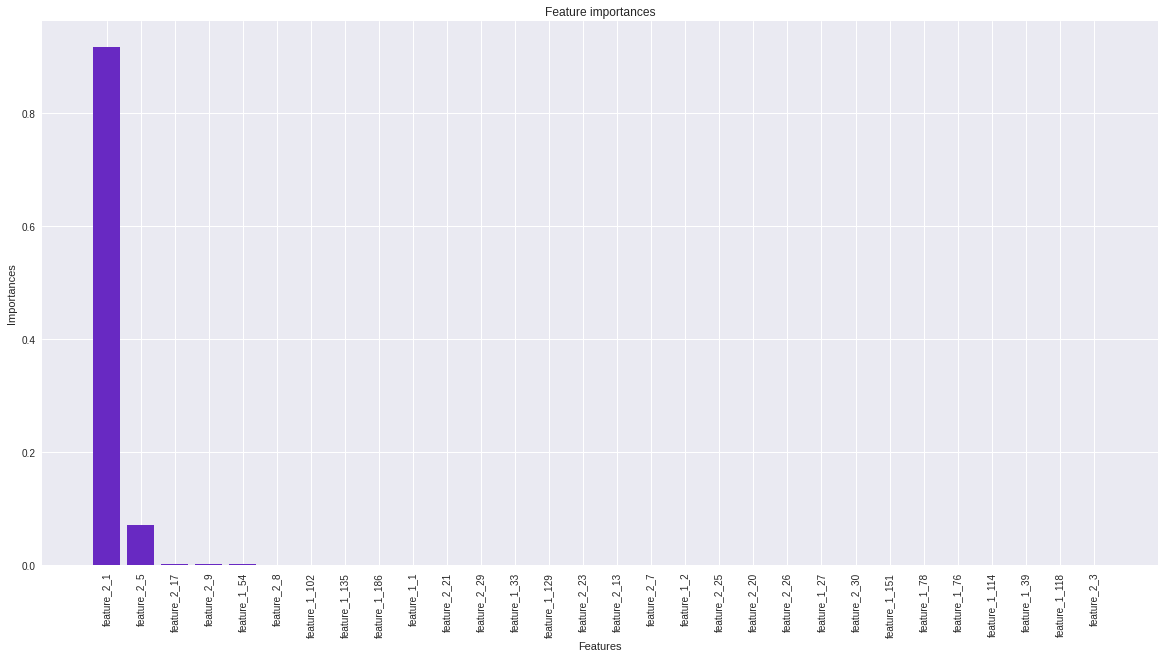

In [31]:
names, importances = pipe4.features.importances()

plt.subplots(figsize=(20, 10))

plt.bar(names[:30], importances[:30], color='#6829c2')

plt.title('Feature importances')
plt.xlabel('Features')
plt.ylabel('Importances')
plt.xticks(rotation='vertical')
plt.show()

__Column importances__

Because getML uses relational learning, we can apply the principles we used to calculate the feature importances to individual columns as well.

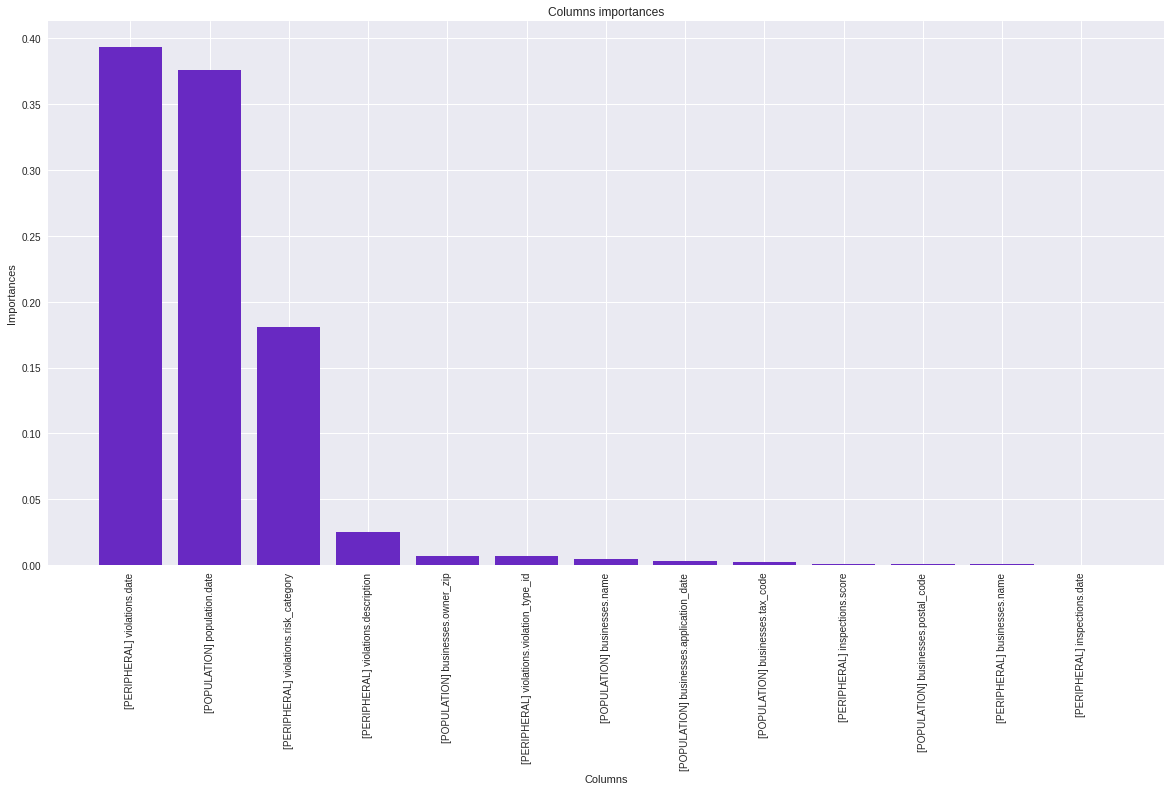

In [32]:
names, importances = pipe4.columns.importances()

plt.subplots(figsize=(20, 10))

plt.bar(names, importances, color='#6829c2')

plt.title('Columns importances')
plt.xlabel('Columns')
plt.ylabel('Importances')
plt.xticks(rotation='vertical')
plt.show()

## 3. Conclusion

...

## References

...

# Next Steps

This tutorial benchmarked getML against academic state-of-the-art algorithms from relational learning literature and getML's qualities with respect to categorical data.

If you are interested in further real-world applications of getML, head back to the [notebook overview](welcome.md) and choose one of the remaining examples.

Here is some additional material from our [documentation](https://docs.getml.com/latest/) if you want to learn more about getML:
* [Feature learning with Multirel](https://docs.getml.com/latest/user_guide/feature_engineering/feature_engineering.html#multirel)
* [Feature learning with Relboost](https://docs.getml.com/latest/user_guide/feature_engineering/feature_engineering.html#relboost)

# Get in contact

If you have any question schedule a [call with Alex](https://go.getml.com/meetings/alexander-uhlig/getml-demo), the co-founder of getML, or write us an [email](team@getml.com). Prefer a private demo of getML? Just contact us to make an appointment.